<a href="https://colab.research.google.com/github/JoohoSon24/tire_competition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/25F/Tire/5-ai-and-datascience-competition.zip .
!mkdir -d data
!unzip 5-ai-and-datascience-competition.zip -d data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: invalid option -- 'd'
Try 'mkdir --help' for more information.
Archive:  5-ai-and-datascience-competition.zip
replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split

from imblearn.over_sampling import SMOTE

tab10_kwargs = {'cmap': 'tab10', 'vmin': 0, 'vmax': 9}

In [4]:
def split_data(df, train=True):
    cols_sim = [f'{ch}{i}' for i in range(256) for ch in ['x', 'y', 'p']]
    X_sum = df.drop(columns=cols_sim)
    X_fem = df[cols_sim]
    if train:
      X_sum = X_sum.drop(columns='Class')
      y = df['Class']
      return X_sum, X_fem, y
    else:
      X_sum = X_sum.drop(columns='ID')
      ids = df['ID']
      return X_sum, X_fem, ids

def numerize(X_sum, oe=None):
  cat_cols = X_sum.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
  num_cols = X_sum.select_dtypes(exclude=['object', 'category', 'bool']).columns.tolist()

  train = oe is None

  Xn = X_sum[num_cols].values
  if train:
    oe = OneHotEncoder(sparse_output=False)
    Xc = oe.fit_transform(X_sum[cat_cols])
  else:
    Xc = oe.transform(X_sum[cat_cols])

  ohe_cols = oe.get_feature_names_out(cat_cols).tolist()
  X = np.concatenate([Xc, Xn], axis=1)
  X = pd.DataFrame(data=X, columns=ohe_cols+num_cols)
  if train:
    return X, oe
  else:
    return X

def apply_smote(X, y, random_state=42):
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

In [5]:
def curve_length(x, y, p):
    P = np.stack([x, y], axis=-1)
    return np.sqrt((np.diff(P, axis=-2) ** 2).sum(axis=-1)).sum(axis=-1)

def stress_length(x, y, p, p_thr=2.5):
    P = np.stack([x, y], axis=-1)  # (N, l, 2)
    mask = (p > p_thr)  # (N, l)

    ls = []
    for i in range(p.shape[0]):
        P_stress = P[i, mask[i], :]  # (l', 2)
        l = np.sqrt((np.diff(P_stress, axis=0) ** 2).sum(axis=-1)).sum(axis=-1)
        ls.append(l)
    ls = np.array(ls)

    return ls

def bend_extent(x, y, p):
    return (y.max(axis=-1) - y.min(axis=-1)) / (x.max(axis=-1) - x.min(axis=-1))

def max_curvature(x, y, p):
    dx  = np.gradient(x, axis=1)
    dy  = np.gradient(y, axis=1)
    ddx = np.gradient(dx, axis=1)
    ddy = np.gradient(dy, axis=1)

    num = np.abs(dx * ddy - dy * ddx)
    den = (dx**2 + dy**2)**1.5 + 1e-9

    curvature = num / den
    max_kappa = np.max(curvature, axis=1)
    return max_kappa

def FEM_feat(rows, fn=lambda x, y, p: p.max(axis=-1)):
    if isinstance(rows, (pd.Series, pd.DataFrame)):
        rows = rows.values
    x, y, p = np.transpose(rows.reshape(-1, rows.shape[1] // 3, 3), axes=(2, 0, 1))
    return fn(x, y, p)

def extract_fem(X_fem, fns=lambda x, y, p: p.max(axis=-1), as_df=False):
  if isinstance(X_fem, (pd.Series, pd.DataFrame)):
    rows = X_fem.values
  else:
    rows = X_fem

  if not isinstance(fns, list):
    fns = [fns]

  X_fem_new = []
  for fn in fns:
    feat = FEM_feat(X_fem, fn=fn)
    X_fem_new.append(feat)
  X_fem_new = np.stack(X_fem_new, axis=1)

  if as_df:
    X_fem_new = pd.DataFrame(data = X_fem_new, columns=[f'FEM_feat_{i}' for i in range(len(fns))])

  return X_fem_new

In [104]:
def conf_table(y_pred, y_true):
    if y_true.ndim == 2:
      y_true = y_true.squeeze(1)
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    tn = ((y_pred == 0) & (y_true == 0)).sum()
    return tp, tn, fp, fn

def plot_curves(p_hat, y_true, ax, curve_type='auroc', n=100):
    if y_true.ndim == 2:
      y_true = y_true.squeeze(1)

    x, y = [], []
    for thr in np.linspace(0, 1, n + 1):
      y_pred = (p_hat > thr).astype(int)

      tp, tn, fp, fn = conf_table(y_pred, y_true)
      if curve_type == 'auroc':
        xx = fp / np.clip((tn + fp), 1, np.inf) # FPR
        yy = tp / np.clip((tp + fn), 1, np.inf) # Recall, TPR
      elif curve_type == 'auprc':
        xx = tp / np.clip((tp + fn), 1, np.inf) # Recall, TPR
        yy = tp / (tp + fp) if tp + fp > 0 else 1 # Precision
      elif curve_type == 'NPV':
        xx = thr
        yy = tn / (tn + fn) if tn + fn > 0 else 1
      elif curve_type == 'profit':
        xx = thr
        yy = tn * 100 - fn * 2000 - 99999 * int(fn + tn > 200 * len(y_true) / 466)
      x.append(xx)
      y.append(yy)

    x = np.array(x)
    y = np.array(y)

    if curve_type in ['auroc', 'auprc']:
      score = -((y[1:] + y[:-1]) / 2 * np.diff(x)).sum()
      ax.plot([0, 1], [0, 1] if curve_type == 'auroc' else [1, 0], 'k--', alpha=0.3)
      xlabel = 'FPR' if curve_type == 'auroc' else 'Recall'
      ylabel = 'TPR' if curve_type == 'auroc' else 'Precision'
      print(f"{curve_type.upper()} score: {score:.4f}")
    elif curve_type == 'NPV':
      score = y[len(y)//2]
      print(f"NPV at thr=0.5: {score:.4f}")
      xlabel = 'Threshold'
      ylabel = 'NPV'
    elif curve_type == 'profit':
      thr_opt = x[np.argmax(y)]
      score = np.max(y)
      print(f"Actual Optimal Profit: {score:.1f} at thr={thr_opt:.4f}")
      xlabel = 'Threshold'
      ylabel = 'Profit'

    ax.plot(x, y, c='red', lw=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f'{curve_type} curve)')

    return score

def plot_profit(p_hat, y_true, ax, quantile=[0.25, 0.75], n=100, xlim=None, ylim=None):
    x, y_expected_mean, y_expected_std = [], [], []
    if y_true is None:
      y_true = np.zeros_like(p_hat)
    for thr in np.linspace(0, 1, n + 1):
      y_pred = (p_hat > thr).astype(int)
      p_selected = p_hat[p_hat < thr]

      #p_selected[p_selected < 0.1] = 0.05

      y_bar = (100 * (1 - p_selected) - 2000 * p_selected).sum() - 99999 * int(len(p_selected) > 200 * len(p_hat) / 466)
      y_std = 2100 * np.sqrt((p_selected * (1 - p_selected)).sum())

      x.append(thr)
      y_expected_mean.append(y_bar)
      y_expected_std.append(y_std)

    x = np.array(x)
    y_expected_mean = np.array(y_expected_mean)
    y_expected_std = np.array(y_expected_std)

    #thr_opt_expected = x[np.argmax(y_expected_mean)]
    thr_opt_expected = 0.016
    p_max_expected = np.max(y_expected_mean)
    p_std_expected = y_expected_std[np.argmax(y_expected_mean)]

    y_pred = (p_hat > thr_opt_expected).astype(int)
    tp, tn, fp, fn = conf_table(y_pred, y_true)
    p_decision = tn * 100 - fn * 2000 - 99999 * int(fn + tn > 200 * len(y_true) / 466)

    print(f"Expected Optimal Profit: {p_max_expected:.1f}(±{p_std_expected:.1f}) at thr={thr_opt_expected:.4f}")
    print(f"Decision Profit: {p_decision:.1f} at thr={thr_opt_expected:.4f}")

    ax.plot(x, y_expected_mean, c='black', lw=1)
    y_q0 = y_q = y_expected_mean + norm.ppf(quantile[0]) * y_expected_std
    for q in quantile:
      y_q = y_expected_mean + norm.ppf(q) * y_expected_std
      ax.plot(x, y_q, c='grey', label=f"{q*100}%", lw=1)
    ax.fill_between(x, y_q0, y_q, fc='gray', alpha=0.3)

    if xlim is not None:
      ax.set_xlim(xlim)
    if ylim is not None:
      ax.set_ylim(ylim)

    ax.set_xlabel('Decision Threshold')
    ax.set_ylabel('Profit')
    ax.set_title(f'Profit curve')
    plt.legend()

    return thr_opt_expected, p_max_expected, p_std_expected, p_decision

def print_result(model, X, y_true):
    y_pred = model.predict(X)
    tp, tn, fp, fn = conf_table(y_pred, y_true)

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = (tp) / (tp + fn)
    precision = (tp) / (tp + fp)
    npv = (tn) / (tn + fn)
    f1 = 2 * (recall * precision) / (recall + precision)

    print(f"Ground truth positive rate: {y_true.mean():.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"NPV: {npv:.4f}")
    print(f"F1 score: {f1:.4f}")
    print()

def final_score(auroc, profit_mean, profit_std):
  return np.sqrt(max(auroc - 0.5, 0) / 0.5 * max(profit_mean, 0) / 20000).item()

In [7]:
def plot_FEM(row, ax):
    if isinstance(row, pd.Series):
        row = row.values
    x, y, p = row.reshape(-1, 3).T
    im = ax.scatter(x, y, c=p, cmap='jet', s=0.5, vmin=1.2, vmax=3)
    plt.colorbar(im)

In [70]:
df_pub = pd.read_csv('data/train.csv')
df_exam = pd.read_csv('data/test.csv')

!cp drive/MyDrive/25F/Tire/fem_ext.csv data/
df_fem_nn = pd.read_csv('data/fem_ext.csv', index_col=0)

In [57]:
X_sum, X_fem, y_ = split_data(df_pub)

le = LabelBinarizer()
y = le.fit_transform(y_)

In [58]:
def cross_validate(model, X, y, cv=5, seed=None):
  if isinstance(y, pd.Series):
    y = y.values
  if y.ndim == 2:
    y = y.squeeze(1)

  N = X.shape[0]
  index = np.random.permutation(np.arange(N))
  X, y = X.iloc[index], y[index]

  block_size = N // cv
  ps, ys = [], []
  for i in range(cv):
    s, e = block_size * i, min(block_size * (i + 1), N)
    mask = ((np.arange(N) >= s) & (np.arange(N) < e))
    X_train, X_val = X.iloc[~mask], X.iloc[mask]
    y_train, y_val = y[~mask], y[mask]

    model.fit(X_train, y_train)
    p = model.predict_proba(X_val)[:, 1]
    ps.append(p)
    ys.append(y_val)
  ps = np.stack(ps)
  ys = np.stack(ys)

  return ps, ys

# 1. Model

In [178]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import shap

model_type = 'xgb' # 'catboost' 'xgb' 'rf'
include_fem = False
augment = False

fem_feat_fns = [
    lambda x, y, p: p.max(axis=-1),
    curve_length,
    stress_length,
    bend_extent,
    max_curvature
]

if model_type == 'catboost':
  model = CatBoostClassifier(
      cat_features = ['Plant', 'Proc_Param6'],
      verbose = 0,
      )
  X = X_sum

elif model_type == 'xgb':
  model = XGBClassifier(
      n_estimators = 500,
      scale_pos_weight=1,
      )
  X, oe = numerize(X_sum)

elif model_type == 'rf':
  model = RandomForestClassifier(
      n_estimators = 1200,
      #class_weight={0: 1, 1: 1},
      max_features = "sqrt",
      #max_depth = 25,
      #min_samples_split = 50,
      #min_samples_leaf = 16,
      bootstrap = True,
      criterion = "log_loss"
      )
  X, oe = numerize(X_sum)

if include_fem:
  X_fem_ext = df_fem_nn #extract_fem(X_fem, fns = fem_feat_fns, as_df = True)
  X = pd.concat([X, X_fem_ext], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
if augment:
  X_train, y_train = apply_smote(X_train, y_train)

In [107]:
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [100]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

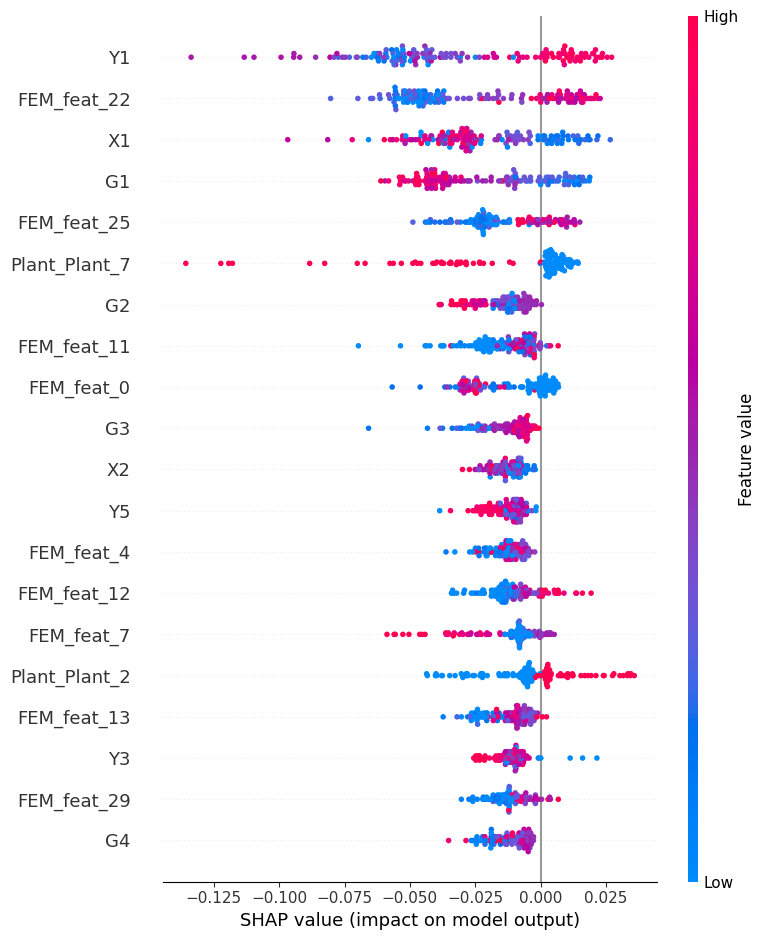

In [86]:
shap_value_pos = shap_values[:, :, 1]
shap.summary_plot(shap_value_pos, X_test, plot_type="dot", show=False)

In [179]:
ps, ys = cross_validate(model, X, y, cv=15)

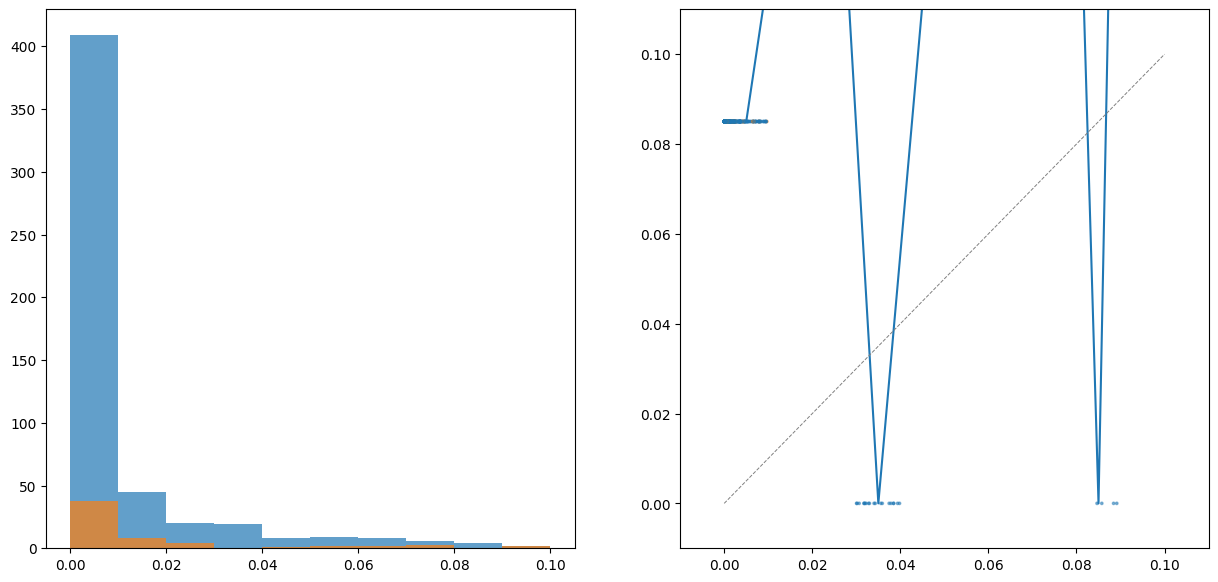

In [180]:
ps = ps.flatten()
ys = ys.flatten()
mask = (ys == 0)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

upper = .1
bins = np.linspace(0, upper, 11)
freq_n, _, im1 = axes[0].hist(ps[mask], bins=bins, alpha=0.7)
freq_p, _, im2 = axes[0].hist(ps[~mask], bins=bins, alpha=0.7)

acc_n = np.cumsum(freq_n)
acc_p = np.cumsum(freq_p)

p_pred = (bins[1:] + bins[:-1]) / 2

ratio = freq_p / (freq_n + freq_p)

bin_indices = np.digitize(ps, bins)
bin_indices = np.clip(bin_indices, 1, len(bins) - 1) - 1
p_bin = ratio[bin_indices]

axes[1].plot(p_pred, ratio)
axes[1].scatter(ps, p_bin, s=3, alpha=0.5, c=ys, **tab10_kwargs)
axes[1].set_xlim(-upper * 0.1, upper * 1.1)
axes[1].set_ylim(-upper * 0.1, upper * 1.1)
axes[1].plot([0, upper], [0, upper], c='grey', lw=0.7, ls='--')

AUROC score: 0.7193
AUPRC score: 0.4120
NPV at thr=0.5: 0.8858
Actual Optimal Profit: 0.0 at thr=0.0000
Expected Optimal Profit: 25738.3(±582.5) at thr=0.0160
Decision Profit: -141999.0 at thr=0.0160
final score (predicted): 0.7513
final score (actual upper bound): 0.0000
final score (decision): 0.0000


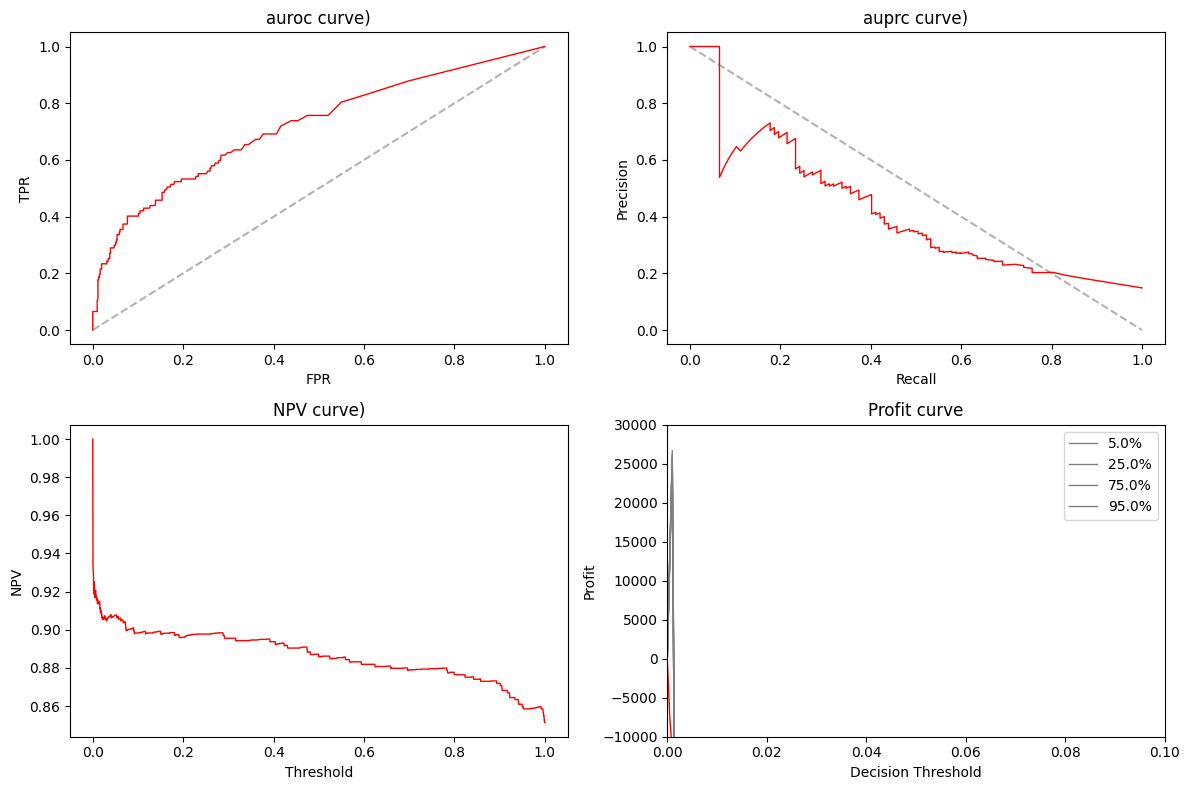

In [181]:
p = ps
y_test = ys

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

auroc = plot_curves(p, y_test, axes[0, 0], curve_type='auroc', n=2000)
auprc = plot_curves(p, y_test, axes[0, 1], curve_type='auprc', n=2000)
npv = plot_curves(p, y_test, axes[1, 0], curve_type='NPV', n=2000)
p_actual = plot_curves(p, y_test, axes[1, 1], curve_type='profit', n=2000)
thr_opt, p_mean, p_std, p_dec = plot_profit(p, y_test, axes[1, 1], quantile=[0.05, 0.25, 0.75, 0.95], n=1000, xlim=(0, 0.1), ylim=(-10000, 30000))
print(f"final score (predicted): {final_score(auroc, p_mean, p_std):.4f}")
print(f"final score (actual upper bound): {final_score(auroc, p_actual, p_std):.4f}")
print(f"final score (decision): {final_score(auroc, p_dec, p_std):.4f}")
plt.tight_layout()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for RandomForestClassifier
param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "max_features": ["sqrt", "log2", None,
                     *np.linspace(0.1, 1.0, 5)],  # 비율 기반
    "max_depth": [None] + list(np.arange(5, 31, 5)),
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced", "balanced_subsample"],
    "criterion": ["gini", "entropy", "log_loss"]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,       # 5-fold cross-validation
    verbose=2,  # Display progress
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1   # Use all available cores
)

# Fit RandomizedSearchCV to the training data
# Make sure y_train is 1D for RandomizedSearchCV
if y.ndim == 2:
    y_flat = y.ravel()
else:
    y_flat = y

random_search.fit(X, y_flat)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# You can access the best model like this:
best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 500, 'min_samples_split': 50, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': np.int64(30), 'criterion': 'log_loss', 'class_weight': None, 'bootstrap': False}
Best cross-validation score:  0.7789434009945806


In [ ]:
df_result = pd.DataFrame(random_search.cv_results_)
params = list(param_dist.keys())
cols = ['mean_fit_time', 'std_fit_time', 'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_features', 'param_max_depth',
       'param_criterion', 'param_class_weight', 'param_bootstrap',
       'mean_test_score', 'std_test_score', 'rank_test_score']

df_result = df_result[cols].rename(columns={f"param_{param}": param for param in params})
df_result

,mean_fit_time,std_fit_time,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,class_weight,bootstrap,mean_test_score,std_test_score,rank_test_score
0,18.570961,0.780026,1200,20,16,0.55,25,log_loss,None,True,0.758099,0.078221,56
1,2.587538,0.520288,300,2,8,sqrt,5,gini,None,True,0.763191,0.072386,42
2,4.238532,0.578787,300,2,2,sqrt,25,entropy,balanced,False,0.760856,0.065679,50
3,10.680776,1.165735,800,5,16,0.325,25,gini,None,False,0.763591,0.076766,40
4,11.691135,1.011861,500,5,8,0.775,None,entropy,None,True,0.760076,0.077081,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.111354,0.133315,300,5,4,0.325,25,gini,balanced_subsample,True,0.762503,0.068153,45
96,3.516737,0.577098,800,20,1,sqrt,5,gini,None,False,0.778340,0.074416,2
97,3.018340,0.376707,300,10,2,0.325,30,entropy,None,False,0.763713,0.062171,39
98,1.490436,0.205357,300,5,16,log2,25,log_loss,balanced_subsample,True,0.756750,0.070805,63


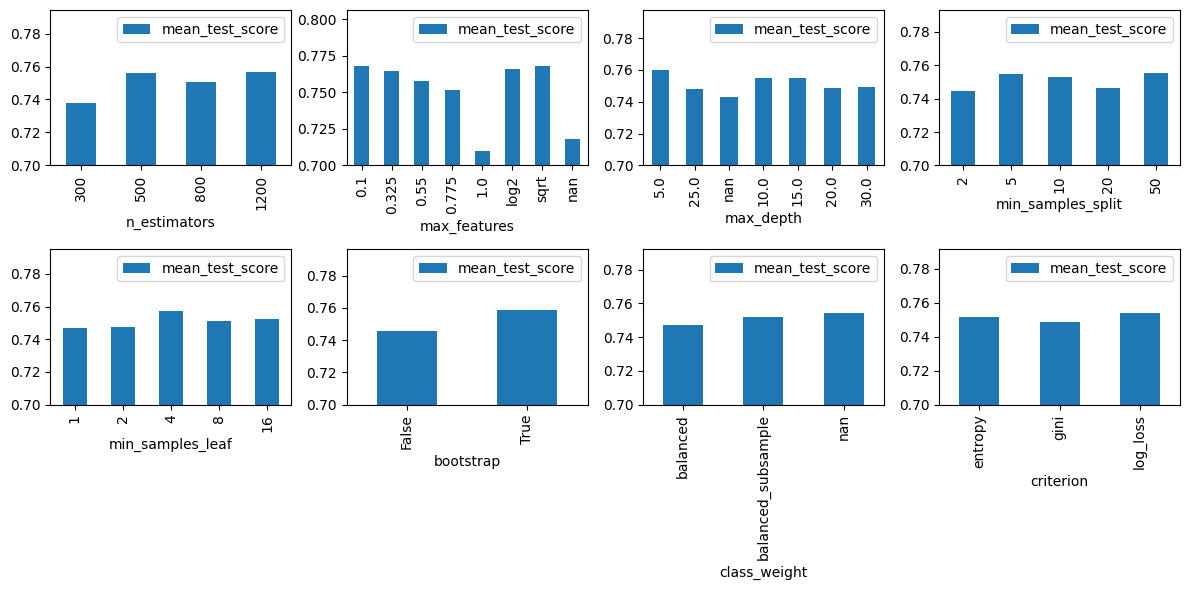

In [ ]:
r, c = 2, len(params) // 2
fig, axes = plt.subplots(r, c, figsize=(12, 6))
for i in range(r):
  for j in range(c):
    ax = axes[i, j]
    param = params[i * c + j]
    assert param in df_result.columns, df_result.columns
    df_mean = df_result[[param, 'mean_test_score']].groupby(by=param, dropna=False).mean()
    df_mean.plot(use_index=True, y='mean_test_score', ax=ax, kind='bar')
    ax.set_ylim(bottom=0.7)
plt.tight_layout()

In [ ]:
df_result.head(10)

,mean_fit_time,std_fit_time,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,class_weight,bootstrap,mean_test_score,std_test_score,rank_test_score
0,18.570961,0.780026,1200,20,16,0.55,25,log_loss,None,True,0.758099,0.078221,56
1,2.587538,0.520288,300,2,8,sqrt,5,gini,None,True,0.763191,0.072386,42
2,4.238532,0.578787,300,2,2,sqrt,25,entropy,balanced,False,0.760856,0.065679,50
3,10.680776,1.165735,800,5,16,0.325,25,gini,None,False,0.763591,0.076766,40
4,11.691135,1.011861,500,5,8,0.775,None,entropy,None,True,0.760076,0.077081,51
5,19.430266,1.370352,800,5,16,1.0,20,log_loss,balanced,False,0.696990,0.113531,91
6,3.840879,0.744334,800,20,16,0.1,20,gini,balanced_subsample,True,0.758075,0.073344,57
7,12.677403,0.766395,800,50,16,None,20,gini,balanced_subsample,False,0.684776,0.094595,94
8,7.279494,0.533197,1200,10,2,log2,30,entropy,balanced_subsample,True,0.773551,0.062160,7
9,28.212599,2.499710,1200,2,8,None,25,entropy,None,False,0.707811,0.097851,89


# 3. Submission

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Expected Optimal Profit: 5492.5(±3524.8) at thr=0.0160
Decision Profit: 3400.0 at thr=0.0160


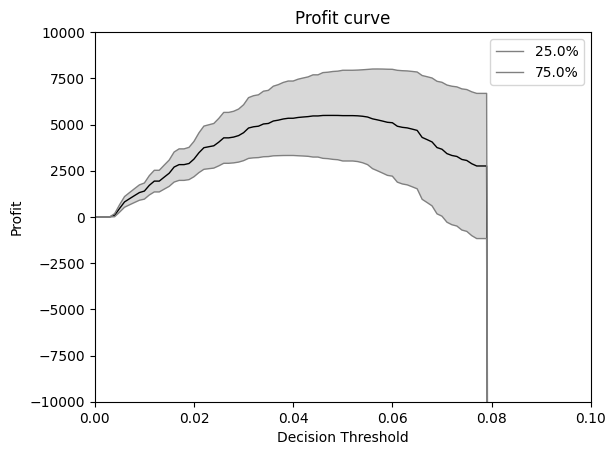

In [162]:
model.fit(X, y)

X_sum_exam, X_fem_exam, ids = split_data(df_exam, train=False)
X_sum_exam = numerize(X_sum_exam, oe=oe)

ax = plt.subplot()
p_exam = model.predict_proba(X_sum_exam)[:, 1]
thr, p_mean, p_std, _ = plot_profit(p_hat=p_exam, y_true=None, ax=ax, n=1000, xlim=(0, 0.1), ylim=(-10000, 10000))

In [169]:
import datetime

thr = 0.03
decision = (p_exam < thr)
print(f"# of selected products: {decision.sum()}")

submission = pd.read_csv('data/sample_submission.csv')

submission['probability'] = np.concatenate([p_exam, p_exam])
submission['decision'] = np.concatenate([decision, decision])

now = datetime.datetime.now(tz=datetime.timezone(datetime.timedelta(hours=9))).strftime("%m-%d-%H-%M")
submission.to_csv(f"submission_HAIYONG_{now}.csv")

# of selected products: 70
